In [1]:
import DiadFit as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
import pickle
import os
from scipy.optimize import newton
from matplotlib.ticker import MultipleLocator

plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"] =12


In [2]:
# this function to find pressure at a given depth based on crustal model alone

def find_pressure_for_depth(desired_depth_km, crust_dens_kgm3=2300, initial_P_kbar=0.903, tolerance=0.0001):

    # Define the function to minimize (the difference between desired_depth_km and the actual depth)
    def depth_difference(P_kbar):
        result_depth_km = pf.convert_pressure_to_depth(P_kbar, crust_dens_kgm3)[0]
        return result_depth_km - desired_depth_km

    # Use newton to find the root of depth_difference
    result = newton(depth_difference, x0=initial_P_kbar, tol=tolerance)

    return result


def find_CO2_density_for_pressure(desired_pressure, T_K, XH2O, initial_guess=0.01, tolerance=0.0001):

    # Define the function to minimize (the difference between desired_pressure and the actual pressure)
    def pressure_difference(CO2_dens_gcm3):
        result_pressure = pf.calculate_entrapment_P_XH2O(CO2_dens_gcm3=CO2_dens_gcm3, T_K=T_K, XH2O=XH2O)['P_kbar_mixCO2_DZ06_Hloss'][0]
        return result_pressure - desired_pressure

    # Use newton to find the root of pressure_difference
    result = newton(pressure_difference, x0=initial_guess, tol=tolerance)

    return result

# Set temperatures for calculations
- We assumed initially a temp of 1150 C (prior to SEM data)
- The mean and median SEM-EDS measured Temp based on Fo content of hosts for the Sept 10th eruption was 1238 C (rounded up to 1240C)
- The whole range of measured temperatures for ol-saturated liquids ever erupted in Kilauea's history is 1100 - 1350 C (DeVitre and Wieser, 2024 GPL). Temp error in MonteCarlo simulations is based on this range: 125C = (1350-1100)/2 

In [3]:
median_meas_T_K=1240+273.15 # this is the average SEM-EDS measured Temp based on FO for the Sept 10th eruption
assumed_T_K=1150+273.15 # Our initial guess based on past eruption history

T=[1100,1150,1240,1350] # Whole range of T for ol-saturated liquids ever erupted in Kilauea history 
T_K=[t+273.15 for t in T]


# Temperature sensititivy (pure CO2 EOS of Span and Wagner 1996)
- We calculate Pressures and Depths for the whole range of T and for CO2 densities between 0 and 1.5 g/cm3
- This part uses the pure CO2 EOS of Span and Wagner (1996)
- We assume a crust density 2300 kg/m3

In [4]:
rhos=np.linspace(0.001,1.4,1000) # set range of densities for plotting later

# Calculate pressures and depths for each density. 
P_values_SW96 = [df.assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar'], crust_dens_kgm3=2300)})
                 .rename(columns={'P_MPa': 'Pressure (MPa)'}) 
                 for df in [pf.calculate_P_for_rho_T(CO2_dens_gcm3=rhos, T_K=T_K[i], EOS='SW96') 
                            for i in range(len(T_K))]]

P_values_SW96[0]

,P_kbar,Pressure (MPa),T_K,CO2_dens_gcm3,Depth (km)
0,0.002596,0.259579,1373.15,0.001000,0.011505
1,0.006236,0.623625,1373.15,0.002400,0.027639
2,0.009883,0.988293,1373.15,0.003801,0.043801
3,0.013536,1.353587,1373.15,0.005201,0.059991
4,0.017195,1.719508,1373.15,0.006602,0.076209
...,...,...,...,...,...
995,19.229108,1922.910784,1373.15,1.394398,85.224074
996,19.287792,1928.779179,1373.15,1.395799,85.484163
997,19.346648,1934.664811,1373.15,1.397199,85.745017
998,19.405677,1940.567731,1373.15,1.398600,86.006636


## MonteCarlo temperature uncertainty on the theoretical FI captured at ~1.5 km (HM reservoir) and ~4km (SC reservoir)
- Here we assume temperature is our first guess of 1150 C, we propagate error only on temperature, based on the whole range of temperatures for ol-saturated liquids erupted in Kilauea history

In [5]:
# Now calculate P and CO2 density for 2 theoretical FI trapped at HM (1.5 km) and SC (4 km) reservoirs

P_MPa_at4km=find_pressure_for_depth(desired_depth_km=4)*100 # The pressure at 4km depth based only on crustal density model
P_MPa_at1km=find_pressure_for_depth(desired_depth_km=1.5)*100 # The pressure at 1.5km depth based only on crustal density model

# Calculate CO2 densities at those pressures assuming pure CO2 and EOS of Span and Wagner 1996
co2_dens_1km_pure_SW96=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=P_MPa_at1km/100,T_K=assumed_T_K)[0]
co2_dens_4km_pure_SW96=pf.calculate_rho_for_P_T(EOS='SW96',P_kbar=P_MPa_at4km/100,T_K=assumed_T_K)[0]

####### Monte Carlo ############

MC_P_starFI_SW96=pf.propagate_FI_uncertainty(T_K=assumed_T_K,
error_T_K=(T_K[T_K.index(max(T_K))]-T_K[T_K.index(min(T_K))])/2, error_type_T_K='Abs', error_dist_T_K='normal',
                        CO2_dens_gcm3=pd.Series([co2_dens_1km_pure_SW96,co2_dens_4km_pure_SW96]),
                        sample_ID=pd.Series(['HM_FI','SC_FI']),
                        crust_dens_kgm3=2300,
                        EOS='SW96',
                        N_dup=1000, fig_i=0, plot_figure=False)[0]


display(MC_P_starFI_SW96)

working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,std_dev_MC_D_km_from_percentile,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,HM_FI,0.116377,1.5,0.338445,0.337409,0.336386,0.030641,0.030091,1.495408,1.490875,0.135802,0.133364,125.0,0,0.0,1423.15,0.116377,None,2300,SW96
1,SC_FI,0.273254,4.0,0.902520,0.903429,0.904394,0.085933,0.083332,4.004030,4.008306,0.380860,0.369332,125.0,0,0.0,1423.15,0.273254,None,2300,SW96


# XH2O sensitivity (Mixed H2O-CO2 EOS of Duan and Zhang, 2006)
- We calculate Pressures and Depths for XH2O 0-0.7 and for CO2 densities between 0 and 1.4 g/cm3
- This part uses the mixed H2O-CO2 EOS of Duan and Zhang (2006)
- We assume a crust density 2300 kg/m3
- We calculate XH2O for our dataset using the polynomials presented in DeVitre and Wieser (2024, GPL), based on MI data for the 2018 LERZ eruption (Wieser et al., 2021)

In [6]:
## import real FI data for plot
real_data=pd.read_excel("P:\WORK-GENERAL\POSTDOC-UCB\BERKELEY-VIBE\Documents\Projects\RapidResponse\Submission files\Rebuttal\S2_SI_Dataset.xlsx",sheet_name="Final_Raman+SEM")
fi23=real_data[~(round(real_data['SO2_Diad_Ratio'],2)>0.22)].copy()
fi23.drop(columns=['Unnamed: 0'], inplace=True)

### Now let's calculate some theoretical FI and the ranges in our data for error propagation

# Load the polynomial using pickle
with open(r"XH2O_from_MI_Kilauea_min.pkl", 'rb') as f:
    Pf_min = pickle.load(f)
with open(r"XH2O_from_MI_Kilauea.pkl", 'rb') as f:
    Pf_av = pickle.load(f)
with open(r"XH2O_from_MI_Kilauea_max.pkl", 'rb') as f:
    Pf_max = pickle.load(f)

XH2O_4km=1-Pf_av(P_MPa_at4km) # This is XH2O at pressure of 90.3 MPa and crustal density model single layer 2300 kg/m3 (equivalent to depth of 4km)
XH2O_1km=1-Pf_av(P_MPa_at1km) # This is XH2O at pressure of 22.6 MPa and crustal density model single layer 2300 kg/m3 (equivalent to depth of 1km)

## For Duan and Zhang, we assume that H has been lost (as this is likely the CO2 density we are measuring), so this newton converges on P_kbar_Hloss
co2_dens_1km_XH2O=find_CO2_density_for_pressure(desired_pressure=P_MPa_at1km/100, T_K=assumed_T_K, XH2O=XH2O_1km)
co2_dens_4km_XH2O=find_CO2_density_for_pressure(desired_pressure=P_MPa_at4km/100, T_K=assumed_T_K, XH2O=XH2O_4km)

print('Approximate XH2O at a depth of 4km based on preferred polynomial: ' + str(np.round((XH2O_4km),3)))
print('Approximate XH2O at a depth of 1.5km based on preferred polynomial: ' + str(np.round((XH2O_1km),3)))

print('\nApproximate CO2 density (g/cm3) at a depth of 4km with XH2O: ' + str(np.round((co2_dens_4km_XH2O),3)))
print('Approximate CO2 density (g/cm3) at a depth of 1.5km with XH2O: ' + str(np.round((co2_dens_1km_XH2O),3)))

print('\nMedian difference in true dataset between preferred XH2O and degassed XH2O: ' + str(np.round(np.median(fi23['XH2O_i5_av']-fi23['XH2O_i5_min']),3)))
print('Median difference in true dataset between preferred XH2O and upper Kilauea limit XH2O: ' + str(np.round(np.median(fi23['XH2O_i5_max']-fi23['XH2O_i5_av']),3)))
print('Half of the whole range of XH2O in our FI dataset calculated from the maximum XH2O-P polynomial: ' + str(np.round((max(fi23['XH2O_i5_max'])-min(fi23['XH2O_i5_max']))/2,3)))

XH2O_error=np.round((max(fi23['XH2O_i5_max'])-min(fi23['XH2O_i5_max']))/2,1)

print('We round up to +-'+str(XH2O_error)+' as the maximum XH2O uncertainty for our FI dataset')



Approximate XH2O at a depth of 4km based on preferred polynomial: 0.043
Approximate XH2O at a depth of 1.5km based on preferred polynomial: 0.097

Approximate CO2 density (g/cm3) at a depth of 4km with XH2O: 0.263
Approximate CO2 density (g/cm3) at a depth of 1.5km with XH2O: 0.106

Median difference in true dataset between preferred XH2O and degassed XH2O: 0.044
Median difference in true dataset between preferred XH2O and upper Kilauea limit XH2O: 0.043
Half of the whole range of XH2O in our FI dataset calculated from the maximum XH2O-P polynomial: 0.096
We round up to +-0.1 as the maximum XH2O uncertainty for our FI dataset


In [7]:
# Calculate single pressures and depths for whole range of densities and XH2O
XH2O=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7]

P_values_DZ06_full = [pf.calculate_entrapment_P_XH2O(CO2_dens_gcm3=rhos,T_K=T_K[1],XH2O=XH2O[i]) for i in range(len(XH2O))] # Calculate P for range of CO2 densities, this returns both pure CO2 EOS and DZ06 XH2O=0.1

# separate the mixed H2O-CO2 results, we assume H is lost as this is most likely what's measured with real samples.
P_values_XH2O = [df[['P_kbar_mixCO2_DZ06_Hloss', 'CO2_dens_gcm3', 'T_K','XH2O']]
                                .rename(columns={'P_kbar_mixCO2_DZ06_Hloss': 'P_kbar'})
                                .assign(**{'Pressure (MPa)': df['P_kbar_mixCO2_DZ06_Hloss'] * 100})
                                .reindex(columns=['P_kbar', 'Pressure (MPa)', 'CO2_dens_gcm3', 'T_K']) 
                                .assign(**{'Depth (km)': pf.convert_pressure_to_depth(P_kbar=df['P_kbar_mixCO2_DZ06_Hloss'], crust_dens_kgm3=2300)})
                                for df in P_values_DZ06_full] 

P_values_XH2O[0]

,P_kbar,Pressure (MPa),CO2_dens_gcm3,T_K,Depth (km)
0,0.002691,0.269090,0.001000,1423.15,0.011926
1,0.006465,0.646479,0.002400,1423.15,0.028652
2,0.010245,1.024516,0.003801,1423.15,0.045407
3,0.014032,1.403206,0.005201,1423.15,0.062191
4,0.017826,1.782551,0.006602,1423.15,0.079003
...,...,...,...,...,...
995,23.887700,2388.769966,1.394398,1423.15,105.871115
996,23.975061,2397.506059,1.395799,1423.15,106.258302
997,24.062716,2406.271649,1.397199,1423.15,106.646796
998,24.150668,2415.066812,1.398600,1423.15,107.036600


## MonteCarlo XH2O uncertainty on the theoretical FI captured at ~1.5 km (HM reservoir) and ~4km (SC reservoir)
- Here we assume temperature is our first guess of 1150 C
- We propagate error only on XH2O
- XH2O error is taken as the rounded up value of Half of the whole range of XH2O in our FI dataset calculated from the maximum XCO2 vs P polynomial from DeVitre and Wieser (2024, GPL). We note this is likely an overestimation of the true XH2O range of our sample set.  

In [8]:
# Montecarlo the errors for just the example FI (stars on graphs)

star_FI=pd.DataFrame({'Sample_ID':['HM_FI','SC_FI'],
                      'CO2_dens_gcm3':[co2_dens_1km_XH2O,co2_dens_4km_XH2O],
                      'XH2O':[XH2O_1km,XH2O_4km]
                    })

MC_P_starFI_XH2O=pf.propagate_FI_uncertainty(T_K=T_K[1],
                        CO2_dens_gcm3=star_FI['CO2_dens_gcm3'],
                        sample_ID=star_FI['Sample_ID'],
                        crust_dens_kgm3=2300,
                        XH2O=star_FI['XH2O'],error_XH2O=XH2O_error,error_type_XH2O='Abs',error_dist_XH2O='normal',
                        N_dup=1000, fig_i=0, plot_figure=False)[0]

MC_P_starFI_XH2O

You have entered a value for XH2O, so we are now using the EOS of Duan and Zhang 2006. If you dont want this, specify XH2O=None
Please note, the DZ2006 EOS is about 5-40X slower to run than the SP94 and SW94 EOS
working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,std_dev_MC_P_kbar_from_percentile,Mean_MC_D_km,Med_MC_D_km,...,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS,error_XH2O,error_type_XH2O,error_dist_XH2O
0,HM_FI,0.106263,1.5,0.338445,0.345048,0.337825,0.034389,0.035565,1.529264,1.497253,...,0,0.0,1423.15,0.106263,None,2300,SW96,0.1,Abs,normal
1,SC_FI,0.263421,4.0,0.902520,0.934385,0.902185,0.092621,0.082491,4.141226,3.998514,...,0,0.0,1423.15,0.263421,None,2300,SW96,0.1,Abs,normal


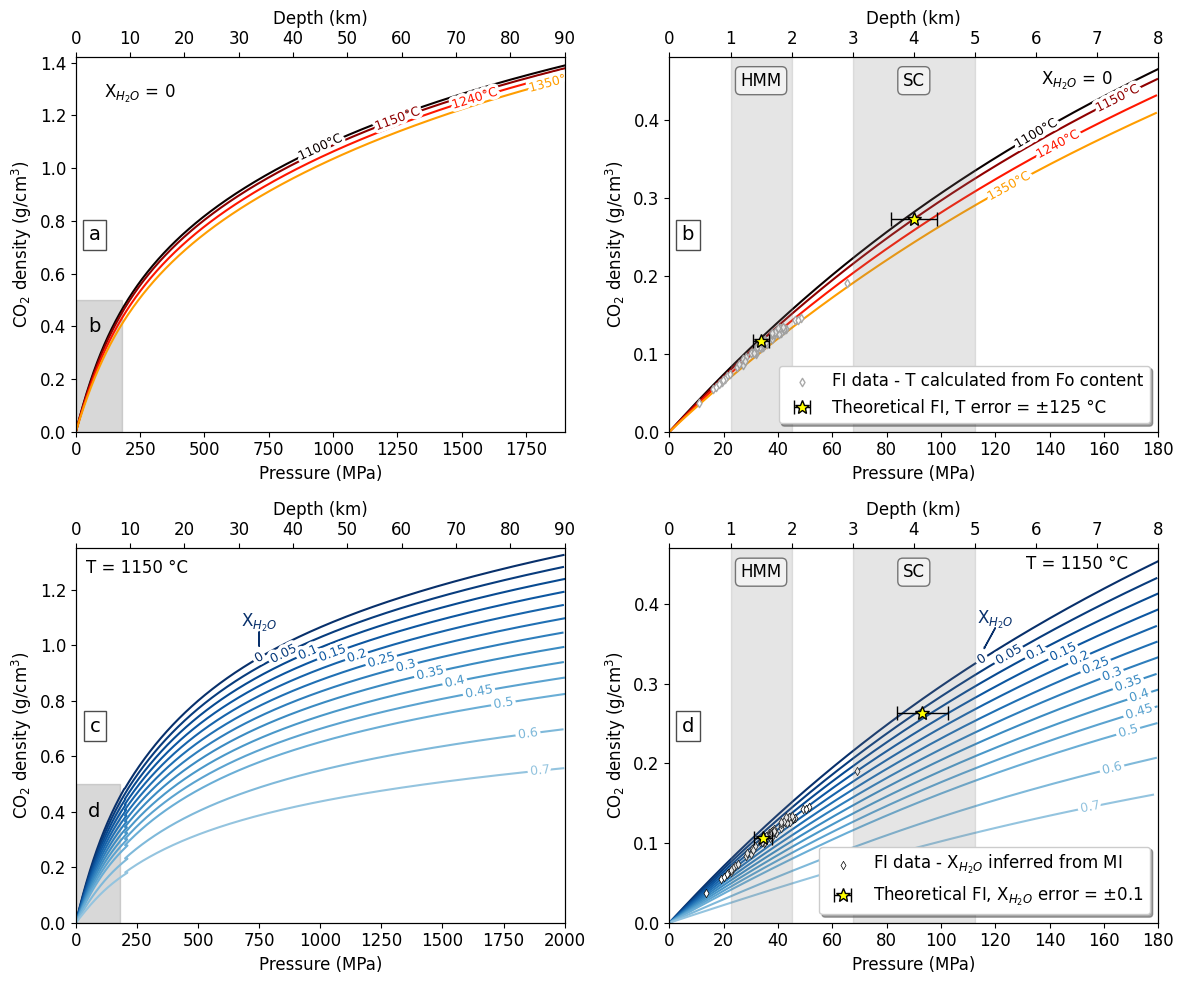

In [10]:
# Color scale for temperature curves
colors = plt.cm.hot(np.linspace(0, 0.6, len(T_K)))

fig, ((ax1,ax3),(ax5,ax7)) = plt.subplots(2,2,figsize=(12,10))

#### Plot panel a ##########

min_P_ax1=0
max_P_ax1=2000 
min_P_ax2 = 0
max_P_ax2 = 180

# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(T_K)):
    ax1.plot(P_values_SW96[i]['Pressure (MPa)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{T[i]}°C', color=colors[i])

# Secondary x-axis for depth in kilometers
ax2 = ax1.twiny()
for i in range(len(T_K)):
    ax2.plot(P_values_SW96[i]['Depth (km)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax1.set_xlabel('Pressure (MPa)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax1.set_ylim(np.round([min(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax1.set_xlim(np.round([min(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax2.set_xlim(np.round([min(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=250
labelLines(ax1.get_lines(), zorder=3, xvals=[700+m,1000+m,1300+m,1600+m], fontsize=9)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax1.text(0.05, 0.50, 'a', transform=ax1.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a


maxrho=round(max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax1.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax1.text(*text_box_coords, 'b', fontsize=14, va='center', ha='left')

ax1.text(250, 1.28, 'X$_{H_2O}$ = 0', ha='center', va='center',zorder=2,color = 'k')

############## Now plot panel b #############

for i in range(len(T_K)):
    ax3.plot(P_values_SW96[i]['Pressure (MPa)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{T[i]}°C', color=colors[i])

# secondary x-axis for depth in kilometers
ax4 = ax3.twiny()
for i in range(len(T_K)):
    ax4.plot(P_values_SW96[i]['Depth (km)'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_SW96[i]['CO2_dens_gcm3'][P_values_SW96[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax3.set_xlabel('Pressure (MPa)')
ax4.set_xlabel('Depth (km)')
ax3.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax4.xaxis.set_major_locator(MultipleLocator(1))
ax3.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax2=np.round([min(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['CO2_dens_gcm3'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax3.set_ylim(ylims_ax2)
ax3.set_xlim(np.round([min(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['Pressure (MPa)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax4.set_xlim(np.round([min(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_SW96[0]['Depth (km)'][P_values_SW96[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax4.fill_between([1, 2], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)
ax4.fill_between([3, 5], ylims_ax2[0],ylims_ax2[1], color='gray', alpha=0.2, zorder=-1)

labelLines(ax3.get_lines(), zorder=3, xvals=[max_P_ax2-45, max_P_ax2-15, max_P_ax2-37,max_P_ax2-55], fontsize=9)

# Add reservoir indicator boxes within the filled areas
ax4.text(1.5, maxrho-0.05, 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax4.text(4, maxrho-0.05, 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)


sc1=ax3.scatter(fi23['SingleFI_P_kbar']*100,fi23['CO2_dens_gcm3'],zorder=3,marker='d',color='white', edgecolor='darkgrey',s=18,label='FI - T calculated from host Fo content')
sc2=ax4.errorbar(MC_P_starFI_SW96['Mean_MC_D_km'],MC_P_starFI_SW96['CO2_dens_gcm3'],xerr=MC_P_starFI_SW96['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1,label='Theoretical FI, T error = ±125 °C')

ax3.text(0.05, 0.50, 'b', transform=ax3.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)
ax3.text(150, maxrho-0.05, 'X$_{H_2O}$ = 0', ha='center', va='center',zorder=2,color = 'k')


#### Plot panel c ##########

colors_XH2O = plt.cm.Blues_r(np.linspace(0, 0.6, len(XH2O)))
filter=(P_values_XH2O[0]['CO2_dens_gcm3'] > 0.4) & (P_values_XH2O[0]['Pressure (MPa)'] < 200)

# Plotting CO2 density against Pressure on the left y-axis
for i in range(len(XH2O)):
    ax5.plot(P_values_XH2O[i]['Pressure (MPa)'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_XH2O[i]['CO2_dens_gcm3'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], label=f'{XH2O[i]}', color=colors_XH2O[i])

# Secondary x-axis for depth in kilometers
ax6 = ax5.twiny()
for i in range(len(XH2O)):
    ax6.plot(P_values_XH2O[i]['Depth (km)'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], P_values_XH2O[i]['CO2_dens_gcm3'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)], color='none')

ax5.set_xlabel('Pressure (MPa)')
ax6.set_xlabel('Depth (km)')
ax5.set_ylabel('CO$_2$ density (g/cm$^3$)')


ax5.set_ylim(np.round([min(P_values_XH2O[0]['CO2_dens_gcm3'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O[0]['CO2_dens_gcm3'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])+0.02],2))

ax5.set_xlim(np.round([min(P_values_XH2O[0]['Pressure (MPa)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O[0]['Pressure (MPa)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-2))
ax6.set_xlim(np.round([min(P_values_XH2O[0]['Depth (km)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)]),max(P_values_XH2O[0]['Depth (km)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax1,max_P_ax1)])],-1))


m=700
labelLines(ax5.get_lines(), zorder=3, xvals=[m+50,m+150,m+250,m+350,m+450,m+550,m+650,m+750,m+850,m+950,m+1050,m+1150,m+1200,m+1250], fontsize=9)

# add panel indicator letter
bbox_props = dict(boxstyle='square', facecolor='white', edgecolor='k', alpha=0.7)
ax5.text(0.05, 0.50, 'c', transform=ax5.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

# plot the insert box corresponding to panel c on panel a


maxrho=round(max(P_values_XH2O[0]['CO2_dens_gcm3'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),1)

x_coordinates = [0, max_P_ax2]
y_coordinates = [0, maxrho]
text_box_coords = [x_coordinates[0] + 50, y_coordinates[1] -0.1]

ax5.fill_between(x_coordinates, 0, y_coordinates[1], color='gray', alpha=0.3)
ax5.text(*text_box_coords, 'd', fontsize=14, va='center', ha='left')

ax5.text(750, 1.08, 'X$_{H_2O}$', ha='center', va='center',zorder=2,color = colors_XH2O[0],fontsize=12)
ax5.arrow(750, 1.05, 0, -0.05, color=colors_XH2O[0])

ax5.text(250, 1.28, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

############## Now plot panel d #############

for i in range(len(XH2O)):
    ax7.plot(P_values_XH2O[i]['Pressure (MPa)'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_XH2O[i]['CO2_dens_gcm3'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], label=f'{XH2O[i]}', color=colors_XH2O[i])

# secondary x-axis for depth in kilometers
ax8 = ax7.twiny()
for i in range(len(XH2O)):
    ax8.plot(P_values_XH2O[i]['Depth (km)'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], P_values_XH2O[i]['CO2_dens_gcm3'][P_values_XH2O[i]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)], color='none')

ax7.set_xlabel('Pressure (MPa)')
ax8.set_xlabel('Depth (km)')
ax7.set_ylabel('CO$_2$ density (g/cm$^3$)')

ax8.xaxis.set_major_locator(MultipleLocator(1))
ax7.xaxis.set_major_locator(MultipleLocator(20))

ylims_ax6=np.round([min(P_values_XH2O[0]['CO2_dens_gcm3'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O[0]['CO2_dens_gcm3'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])+0.02],2)

ax7.set_ylim(ylims_ax6)
ax7.set_xlim(np.round([min(P_values_XH2O[0]['Pressure (MPa)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O[0]['Pressure (MPa)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])],-1))
ax8.set_xlim(np.round([min(P_values_XH2O[0]['Depth (km)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)]),max(P_values_XH2O[0]['Depth (km)'][P_values_XH2O[0]['Pressure (MPa)'].between(min_P_ax2,max_P_ax2)])]))

ax8.fill_between([1, 2], ylims_ax6[0],ylims_ax6[1], color='gray', alpha=0.2, zorder=-1)
ax8.fill_between([3, 5], ylims_ax6[0],ylims_ax6[1], color='gray', alpha=0.2, zorder=-1)

m=65
labelLines(ax7.get_lines(), zorder=3, xvals=[max_P_ax2-m, max_P_ax2-m+10, max_P_ax2-m+20,max_P_ax2-m+30,max_P_ax2-m+36,max_P_ax2-m+42,max_P_ax2-m+48,max_P_ax2-m+54,max_P_ax2-m+58,max_P_ax2-m+58,max_P_ax2-m+54,max_P_ax2-m+48,max_P_ax2-m+40,max_P_ax2-m+32], fontsize=9)

# Add reservoir indicator boxes within the filled areas
ax8.text(1.5, maxrho-0.06, 'HMM', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)
ax8.text(4, maxrho-0.06, 'SC', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5,boxstyle='round'),zorder=2)

sc3=ax7.scatter(fi23['P_kbar_mixCO2_DZ06_Hloss_i5_av']*100,fi23['CO2_dens_gcm3'],zorder=3,marker='d',color='white', edgecolor='k',s=18,linewidths=0.5,label='FI - XH2O inferred from MI')
sc4=ax8.errorbar(MC_P_starFI_XH2O['Mean_MC_D_km'],MC_P_starFI_XH2O['CO2_dens_gcm3'],xerr=MC_P_starFI_XH2O['std_dev_MC_D_km'],fmt='*',zorder=3,markersize=10,ecolor='k',capsize=5,mfc='yellow',mec='k',elinewidth=1,label='Theoretical FI, error XH2O = ±0.1')


ax7.text(0.05, 0.50, 'd', transform=ax7.transAxes, fontsize=14, va='bottom', ha='right',bbox=bbox_props)

ax7.text(150, maxrho-0.05, 'T = 1150 °C', ha='center', va='center',zorder=2,color = 'k')

ax7.text(120, maxrho-0.12, 'X$_{H_2O}$', ha='center', va='center',zorder=2,color = colors_XH2O[0],fontsize=12)
ax7.arrow(120, maxrho-0.13, -4, -0.025, color=colors_XH2O[0])


ax4.legend([sc1, sc2],  ['FI data - T calculated from Fo content','Theoretical FI, T error = ±125 °C'], loc='lower right',fancybox=True, shadow=True)
ax8.legend([sc3, sc4],  ['FI data - X$_{H_2O}$ inferred from MI','Theoretical FI, X$_{H_2O}$ error = ±0.1'], loc='lower right',fancybox=True, shadow=True)

fig.tight_layout()

plt.show()
plt.rcParams["pdf.fonttype"]=42
fig.savefig(os.getcwd()+'/'+'Figures\Fig1_new_Tsensitivity.pdf')
fig.savefig(os.getcwd()+'/'+'Figures\Fig1_new_Tsensitivity.png',dpi=300)


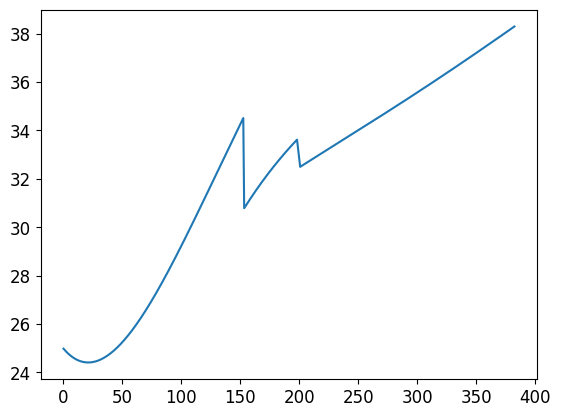

In [16]:
Pcorr=P_values_XH2O[0].copy()

Pcorr['P_correction%_atXH2O_0.1']=100*(P_values_XH2O[4]['Pressure (MPa)']-P_values_XH2O[0]['Pressure (MPa)'])/P_values_XH2O[0]['Pressure (MPa)']
Pcorr['P_correction_atXH2O_0.1']=P_values_XH2O[4]['Pressure (MPa)']-P_values_XH2O[0]['Pressure (MPa)']
Pcorr['D_correction_atXH2O_0.1']=P_values_XH2O[4]['Depth (km)']-P_values_XH2O[0]['Depth (km)']

plt.plot(Pcorr[0:500]['Pressure (MPa)'],Pcorr[0:500]['P_correction%_atXH2O_0.1'])
# plt.plot(Pcorr[500:900]['Pressure (MPa)'],Pcorr[500:900]['P_correction%_atXH2O_0.1'])